In [ ]:
!pip install tensorflow
!pip  install absl-py
!pip install pydot
!pip install graphviz

In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import tensorflow
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import MaxPooling1D, Dropout, Activation, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)


pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.5.0


In [2]:
#import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K

In [3]:
prefix = '../Datasets_Small/'
train_df = pd.read_csv(prefix + 'train.csv', sep=',')
test_df = pd.read_csv(prefix + 'test.csv', sep=',')
eval_df = pd.read_csv(prefix + 'val.csv', sep=',')

In [4]:
train_df= train_df.drop('avg_res_realtor',axis =1)
test_df=test_df.drop('avg_res_realtor',axis =1)
eval_df=eval_df.drop('avg_res_realtor',axis =1)


In [5]:
X_train = train_df.drop('feedback_realtor', axis=1)
Y = train_df['feedback_realtor'].values

In [6]:
X_test = eval_df.drop('feedback_realtor', axis=1)
y_test = eval_df['feedback_realtor'].values

In [7]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
y_test = encoder.transform(y_test)

In [8]:
y_train = encoded_Y

In [9]:
y_test = np.array(y_test).reshape((-1, 1))
y_train = np.array(y_train).reshape((-1, 1))

In [10]:
X1_test = X_test['text']
X1_train = X_train['text']

In [17]:
tokenizer = Tokenizer(lower=True, split=" ",num_words=50000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [18]:
X1_train

array([[49, 54,  6, ...,  0,  0,  0],
       [62, 40,  1, ...,  0,  0,  0],
       [ 3, 55, 40, ...,  0,  0,  0],
       ...,
       [ 3, 55, 40, ...,  0,  0,  0],
       [49, 54, 34, ...,  0,  0,  0],
       [ 3, 39, 41, ...,  0,  0,  0]], dtype=int32)

In [11]:
X2_train = X_train[['income_group', 'employment_group', 'age_decade','marital_status','nationality']]
X2_test = X_test[['income_group', 'employment_group', 'age_decade','marital_status','nationality']]

In [12]:
y_test.shape

(40000, 1)

In [13]:
X2_test.shape

(40000, 5)

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
def prepare_inputs(X2_train, X2_test):
    ohe = OneHotEncoder()
    ohe.fit(X2_train)
    X_train_enc = ohe.transform(X2_train)
    X_test_enc = ohe.transform(X2_test)
    return X_train_enc, X_test_enc

In [16]:
X_train_enc, X_test_enc = prepare_inputs(X2_train, X2_test)

In [17]:
X_train_enc.shape

(241988, 30)

In [25]:
X2_train = X_train_enc
X2_test = X_test_enc

In [26]:
input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(30,))

In [27]:
# Text Vectors
MAX_FEATURES = 70000
EMBED_DIM = 200
MAXLEN = 200

In [28]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=3e-05)

In [29]:
#embedding_layer = Embedding(input_dim=MAX_FEATURES, output_dim=EMBED_DIM, input_length=MAXLEN)(input_1)
#LSTM_Layer_1 = Bidirectional(LSTM(EMBED_DIM,recurrent_dropout=0.3, kernel_regularizer=tensorflow.keras.regularizers.l2(0.01)))(embedding_layer)


embedding_layer = Embedding(input_dim=MAX_FEATURES, output_dim=EMBED_DIM, input_length=MAXLEN)(input_1)
LSTM_Layer_1 = Bidirectional(LSTM(EMBED_DIM, dropout=0.1)) (embedding_layer)
dense_layer_1 = Dense(90, activation='relu')(input_2)
dense_layer_2 = Dense(60, activation='relu')(dense_layer_1)
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(30, activation='relu')(concat_layer)
output = Dense(1, activation='sigmoid')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)


model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc', 'AUC'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     10000000    input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 90)           2790        input_2[0][0]                    
______________________________________________________________________________________________

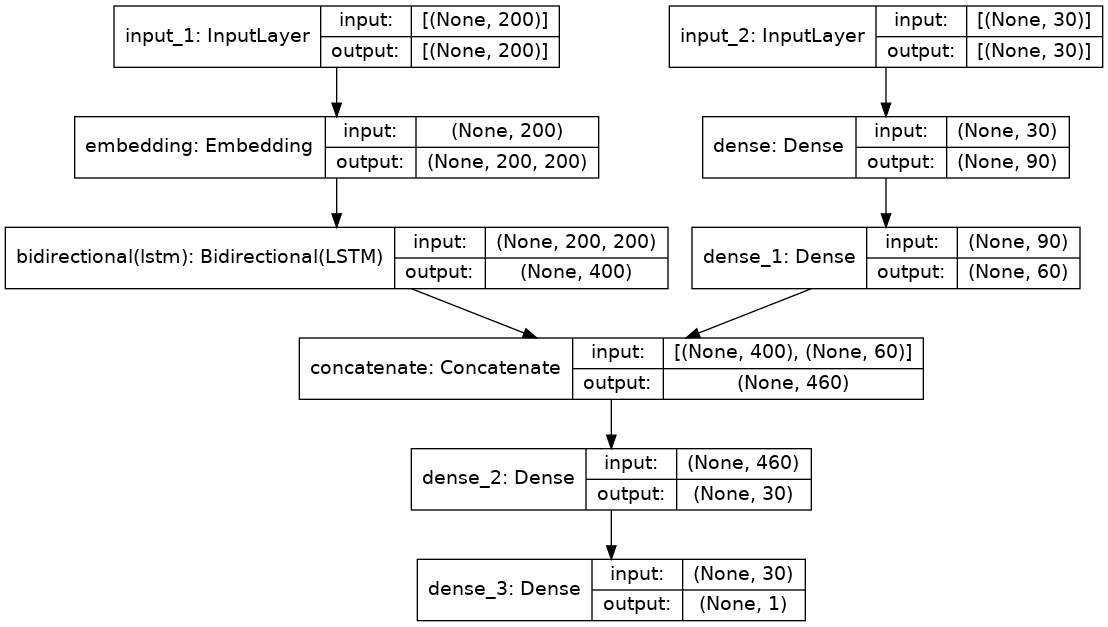

In [30]:
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [31]:
x_test=[X1_test, X2_test] 
y_test=y_test

In [32]:
strategy = tf.distribute.get_strategy()
batch_size  = 256 * strategy.num_replicas_in_sync
epochs = 10

In [33]:
PATH_DATA = './Datasets_Small/'
PATH_MODELS = PATH_DATA + "models/1807_smalldata_lr=0.001/"
PATH_CHECKPOINTS = PATH_MODELS + "checkpoints/"


# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", verbose=1, patience=1),
    ModelCheckpoint(
        PATH_CHECKPOINTS + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

In [34]:
# Fit the model
steps_per_epoch = int(np.floor((len(X1_train) / batch_size)))
print(
    f"Model Params.\nbatch_size: {batch_size}\nEpochs: {epochs}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
)

hist = model.fit(
   x=[X1_train, X2_train],
    y=y_train, 
    batch_size=batch_size, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=(x_test, y_test),
)

Model Params.
batch_size: 256
Epochs: 10
Step p. Epoch: 945

Epoch 1/10
945/945 [==============================] - 2726s 3s/step - loss: 0.6630 - acc: 0.5820 - auc: 0.6233 - val_loss: 0.6439 - val_acc: 0.6020 - val_auc: 0.6593

Epoch 00001: val_loss improved from inf to 0.64388, saving model to ./Datasets_Small/models/1807_smalldata_lr=0.001/checkpoints/2021-07-18_1917_Model_01_0.6439.h5
Epoch 2/10
945/945 [==============================] - 2625s 3s/step - loss: 0.6154 - acc: 0.6399 - auc: 0.7053 - val_loss: 0.6398 - val_acc: 0.6218 - val_auc: 0.6641

Epoch 00002: val_loss improved from 0.64388 to 0.63976, saving model to ./Datasets_Small/models/1807_smalldata_lr=0.001/checkpoints/2021-07-18_1917_Model_02_0.6398.h5
Epoch 3/10
945/945 [==============================] - 2739s 3s/step - loss: 0.5789 - acc: 0.6746 - auc: 0.7515 - val_loss: 0.6542 - val_acc: 0.6313 - val_auc: 0.6621

Epoch 00003: val_loss did not improve from 0.63976
Epoch 00003: early stopping


In [35]:
model.save("MM_LSTM_4_epochs")

INFO:tensorflow:Assets written to: MM_LSTM_4_epochs_1707_small_data/assets


INFO:tensorflow:Assets written to: MM_LSTM_4_epochs_1707_small_data/assets
